# Bahar  Almasi

#  Dataset Overview – Bank Customer Complaints

The Consumer Financial Protection Bureau (CFPB) collects consumer complaints about financial products and services. Each complaint typically includes a detailed narrative written by the consumer and is associated with a specific product category (e.g., mortgage, credit card, student loan, etc.).

The goal of this project is to build a Natural Language Processing (NLP) model that can accurately predict the product category based on the consumer complaint narrative. This can help financial institutions and regulatory bodies automatically categorize complaints, prioritize issues, and take timely action.



This dataset contains customer complaints submitted to a financial institution regarding various banking products and services. 


### Objective
To develop a multi-class text classification model that:

Takes as input: the free-text complaint (consumer_complaint_narrative)

Outputs: the predicted product category (product)

Applies preprocessing, feature extraction, and machine learning classification techniques

Evaluates performance using standard classification metrics




### Input and Output
Input Feature: consumer_complaint_narrative (free-text complaint by customer)

Target Variable: product (categorical label representing the product category)



### Importance of the Project
Automates the classification of large volumes of textual complaints

Improves operational efficiency in consumer complaint handling

Enables faster issue tracking and response by identifying complaint trends

Valuable for both regulatory reporting and internal analytics within financial organizations

---

##  Dataset Summary

- **Source**: Internal complaint log/report
- **File Used**: `complaints.csv` 
- **Total Records**: 11,657
- **Total Features (Columns)**: 10

---

##  Main Features

| Feature                        | Data Type       | Missing Values |
| ------------------------------ | --------------- | -------------- |
| `date_received`                | object (string) | 0              |
| `product`                      | object          | 0              |
| `sub_product`                  | object          | 158,322        |
| `issue`                        | object          | 0              |
| `sub_issue`                    | object          | 343,335        |
| `consumer_complaint_narrative` | object          | 489,151        |
| `company_public_response`      | object          | 470,833        |
| `company`                      | object          | 0              |
| `state`                        | object          | 4,887          |
| `zipcode`                      | object          | 4,505          |
| `tags`                         | object          | 477,998        |
| `consumer_consent_provided`    | object          | 432,499        |
| `submitted_via`                | object          | 0              |
| `date_sent_to_company`         | object          | 0              |
| `company_response_to_consumer` | object          | 0              |
| `timely_response`              | object          | 0              |
| `consumer_disputed?`           | object          | 0              |
| `complaint_id`                 | int64           | 0              |


##  Target Variable (for Classification)

Depending on the modeling goal, the target could be:

- A **product category** (e.g., "Credit Card", "Mortgage")
- A **sentiment/status label** (e.g., "Resolved", "Unresolved") if engineered

---

##  Data Characteristics

- **Text Data**: The core focus is on analyzing the `complaint_text` field
- **Multiclass Labels**: Possible if we're classifying by product or issue type
- **Categorical Columns**: `product`, `sub_product`, `issue`, `company`, `state`
- **Date Columns**: `date_received`
- **No major numeric features**: Scaling/PCA not required unless engineered

---

##  Initial Observations

- The dataset has enough **volume and variety** to support robust NLP modeling.
- We can use **TF-IDF**, **Bag-of-Words**, or **pretrained embeddings** to represent the text data.
- Combining categorical metadata with text features may improve model performance.



In [3]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [4]:

!pip install nltk textblob


In [301]:
# =============================
# Standard library
# =============================
from pathlib import Path
import re
import string

# =============================
# Persistence / utilities
# =============================
import joblib

# =============================
# Data handling
# =============================
import numpy as np
import pandas as pd

# =============================
# Visualization
# =============================
import matplotlib.pyplot as plt
import seaborn as sns

# =============================
# NLP / Text processing
# =============================
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from bs4 import BeautifulSoup
import regex as re_ux  # Unicode-aware regex (e.g., Emoji class)

# =============================
# SciPy utilities
# =============================
from scipy.stats import f_oneway, chi2_contingency, randint
from scipy.sparse import hstack, csr_matrix

# =============================
# Scikit-learn: model selection & validation
# =============================
from sklearn.model_selection import (
    train_test_split,
    StratifiedShuffleSplit,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
)

# =============================
# Scikit-learn: metrics
# =============================
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)

# =============================
# Scikit-learn: models
# =============================
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# =============================
# XGBoost
# =============================
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb  # low-level API (optional)

# =============================
# Scikit-learn: preprocessing & feature engineering
# =============================
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



In [6]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/baharalmasi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/baharalmasi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/baharalmasi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
df = pd.read_csv("/Users/baharalmasi/Desktop/consumer_complaints.csv")
df.head()

/var/folders/43/0xfmd9ss7d73pj4cwk4r4m180000gn/T/ipykernel_1631/715333342.py:1: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/baharalmasi/Desktop/consumer_complaints.csv")


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [8]:
df.shape

(555957, 18)

# Handelling Missing Values

In [10]:
# Drop a single column from the DataFrame
df = df.drop(['zipcode', 'consumer_consent_provided','complaint_id'], axis=1)



In [11]:
df.isnull().sum()

date_received                        0
product                              0
sub_product                     158322
issue                                0
sub_issue                       343335
consumer_complaint_narrative    489151
company_public_response         470833
company                              0
state                             4887
tags                            477998
submitted_via                        0
date_sent_to_company                 0
company_response_to_consumer         0
timely_response                      0
consumer_disputed?                   0
dtype: int64

In [12]:


# Define columns with high missing values
high_missing_cols = ['sub_product', 'sub_issue', 'company_public_response', 'tags']

# Create a copy of the dataframe to avoid modifying the original
df_copy = df.copy()

# Replace missing values with a placeholder for testing
for col in high_missing_cols:
    df_copy[col] = df_copy[col].fillna('Missing')

# Run chi-square test for each feature vs the target variable (product)
for col in high_missing_cols:
    contingency_table = pd.crosstab(df_copy[col], df_copy['product'])
    
    if contingency_table.shape[0] > 1:
        chi2, p, dof, ex = chi2_contingency(contingency_table)
        print(f"Feature: {col}")
        print(f"Chi-square test p-value: {p:.4f}")
        if p < 0.05:
            print("→ This feature has a statistically significant relationship with the target.\n")
        else:
            print("→ This feature does NOT have a statistically significant relationship with the target.\n")
    else:
        print(f"Feature {col} has only one category after filling missing values.\n")


Feature: sub_product
Chi-square test p-value: 0.0000
→ This feature has a statistically significant relationship with the target.

Feature: sub_issue
Chi-square test p-value: 0.0000
→ This feature has a statistically significant relationship with the target.

Feature: company_public_response
Chi-square test p-value: 0.0000
→ This feature has a statistically significant relationship with the target.

Feature: tags
Chi-square test p-value: 0.0000
→ This feature has a statistically significant relationship with the target.



In [13]:
# Fill missing values with 'Missing' as a category
df['sub_product'] = df['sub_product'].fillna('Missing')
df['sub_issue'] = df['sub_issue'].fillna('Missing')
df['company_public_response'] = df['company_public_response'].fillna('Missing')
df['tags'] = df['tags'].fillna('Missing')
df['state'] = df['state'].fillna('Unknown')
df = df.dropna(subset=['consumer_complaint_narrative'])


In [14]:
df.isnull().sum()

date_received                   0
product                         0
sub_product                     0
issue                           0
sub_issue                       0
consumer_complaint_narrative    0
company_public_response         0
company                         0
state                           0
tags                            0
submitted_via                   0
date_sent_to_company            0
company_response_to_consumer    0
timely_response                 0
consumer_disputed?              0
dtype: int64

# Outlier Detection and Handling

### Visualize Narrative Length Distribution

In [17]:
# Add narrative_length column based on the original complaint text
df['narrative_length'] = df['consumer_complaint_narrative'].apply(lambda x: len(str(x).split()))


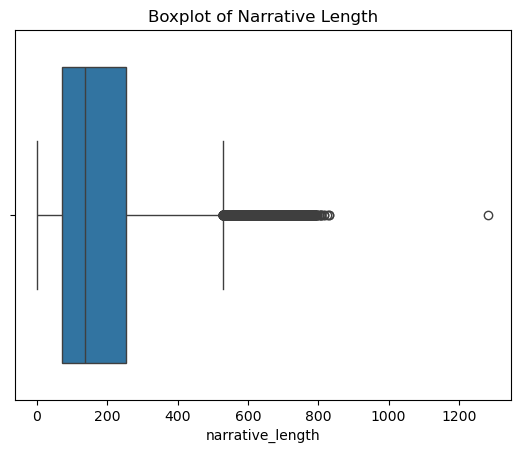

In [18]:


# Boxplot to visualize outliers
sns.boxplot(x=df['narrative_length'])
plt.title('Boxplot of Narrative Length')
plt.show()


In [19]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['narrative_length'].quantile(0.25)
Q3 = df['narrative_length'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['narrative_length'] < lower_bound) | (df['narrative_length'] > upper_bound)]
print(f"Number of outliers: {len(outliers)}")


Number of outliers: 4374


# IQR Capping

In [21]:
# Calculate IQR
Q1 = df['narrative_length'].quantile(0.25)
Q3 = df['narrative_length'].quantile(0.75)
IQR = Q3 - Q1

# Define capping limits
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cap the outliers
df['narrative_length_capped'] = df['narrative_length'].apply(
    lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x)
)


In [22]:
# Recalculate IQR for the capped column
Q1_capped = df['narrative_length_capped'].quantile(0.25)
Q3_capped = df['narrative_length_capped'].quantile(0.75)
IQR_capped = Q3_capped - Q1_capped

lower_bound_capped = Q1_capped - 1.5 * IQR_capped
upper_bound_capped = Q3_capped + 1.5 * IQR_capped

# Count number of outliers after capping
outliers_after_capping = df[(df['narrative_length_capped'] < lower_bound_capped) | (df['narrative_length_capped'] > upper_bound_capped)]

print(f'Number of outliers after capping: {len(outliers_after_capping)}')


Number of outliers after capping: 0


###  Outlier Treatment: `narrative_length` Feature

**Method:** *IQR-based Capping (Winsorization)*  
To handle the outliers in the `narrative_length` feature, we used the **Interquartile Range (IQR)** method. Instead of removing the rows, we applied **capping**, replacing values above the upper bound and below the lower bound with their respective thresholds.

**Why not remove the outliers?**  
Removing would reduce the dataset size and may eliminate important variations in customer complaints. Capping is preferred as it retains all records while reducing the influence of extreme values.

**Why not use Z-score or log transform?**  
- Z-score assumes normal distribution, which is not the case for text length data.
- Log transformation helps reduce skewness but does not cap outliers directly.

**Technical Explanation (Interview-Ready):**  
> *"To limit the impact of extreme values in the `narrative_length`, I capped the values based on the IQR method. This ensures robust handling of outliers in skewed distributions without losing data integrity."*

**Conclusion:**  
IQR-based capping is a safe and effective choice when dealing with non-normally distributed features such as text-derived numeric variables.



# Univariate

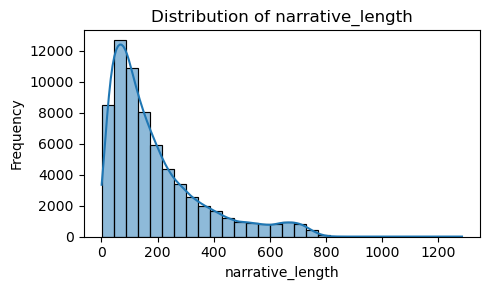

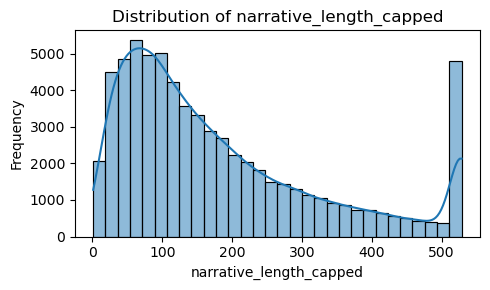

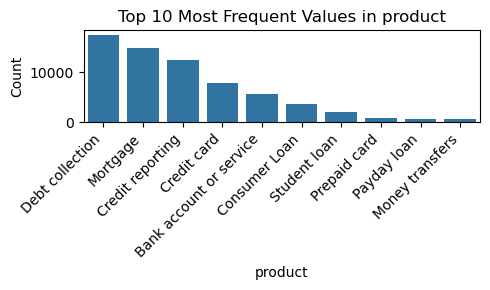

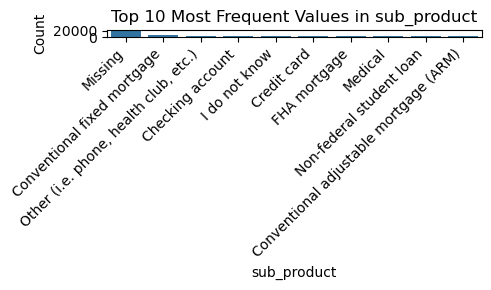

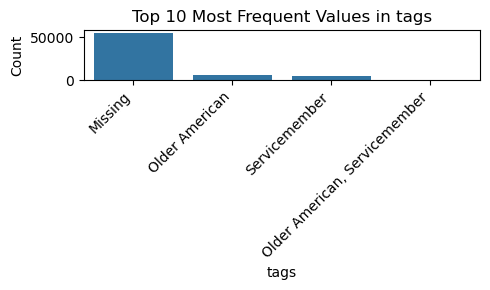

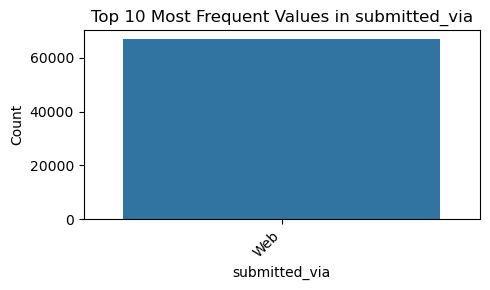

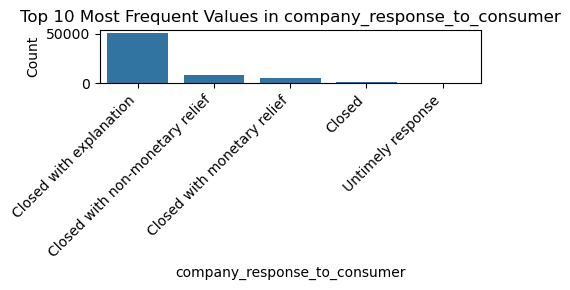

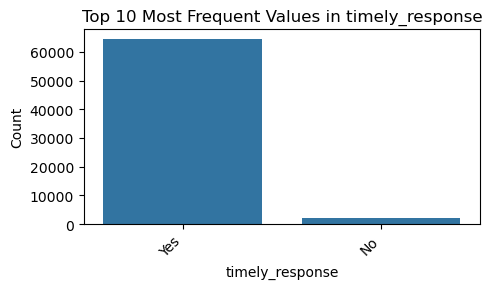

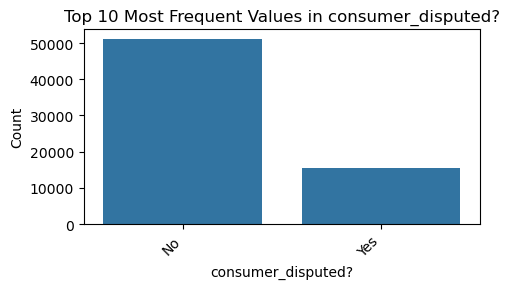

In [25]:
# Separate numeric columns (int and float)
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Include derived numeric column 'narrative_length' if available
if 'narrative_length' in df.columns and 'narrative_length' not in numerical_cols:
    numerical_cols.append('narrative_length')

# Separate categorical columns (object types)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Exclude irrelevant or high-cardinality categorical features
exclude_cols = ['consumer_complaint_narrative', 'company_public_response', 'complaint_id', 'sub_issue']
categorical_cols = [
    col for col in categorical_cols
    if col not in exclude_cols and df[col].nunique() < 50
]

# Plot histograms for numerical features
for col in numerical_cols:
    plt.figure(figsize=(5, 3))
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Plot bar charts for top 10 categories in each categorical feature
for col in categorical_cols:
    plt.figure(figsize=(5, 3))
    value_counts = df[col].value_counts().head(10)
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.title(f'Top 10 Most Frequent Values in {col}')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()




# Bivariate

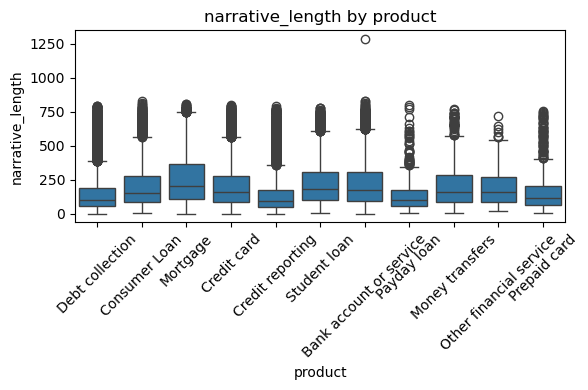

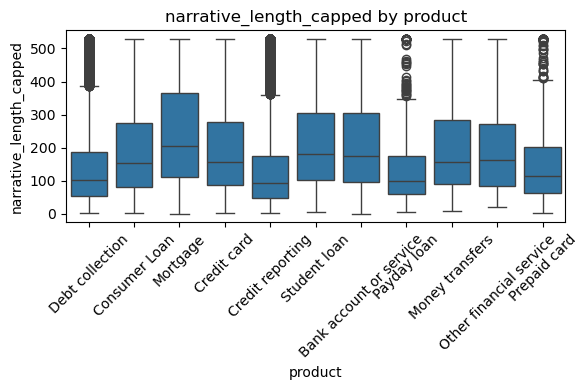

/var/folders/43/0xfmd9ss7d73pj4cwk4r4m180000gn/T/ipykernel_1631/3788254063.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target_col, bbox_to_anchor=(1.05, 1), loc='upper left')


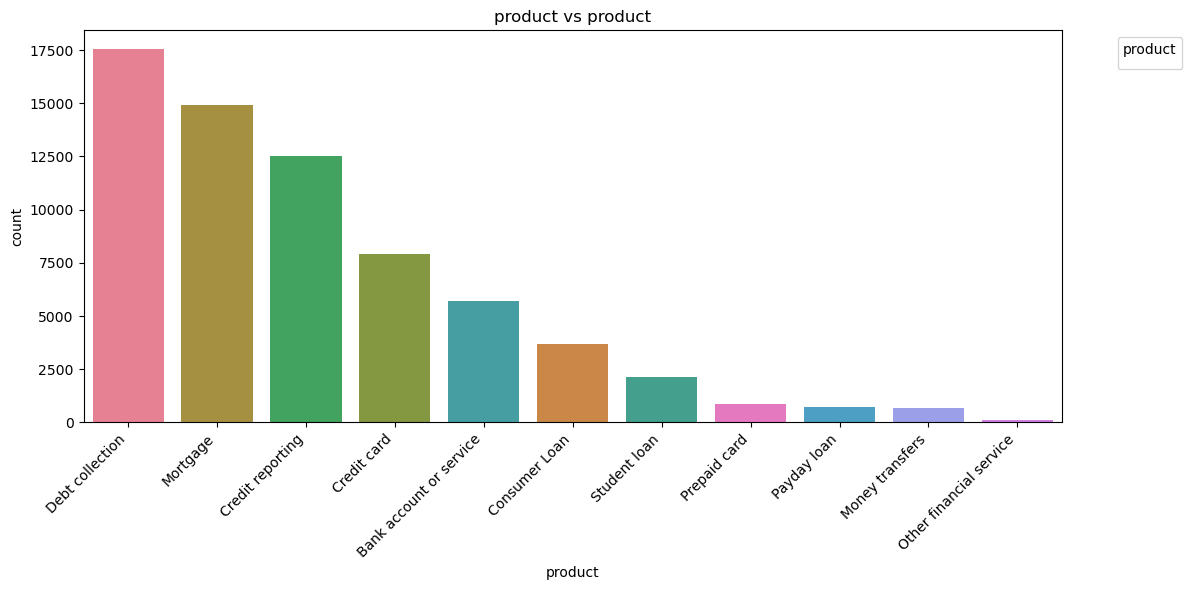

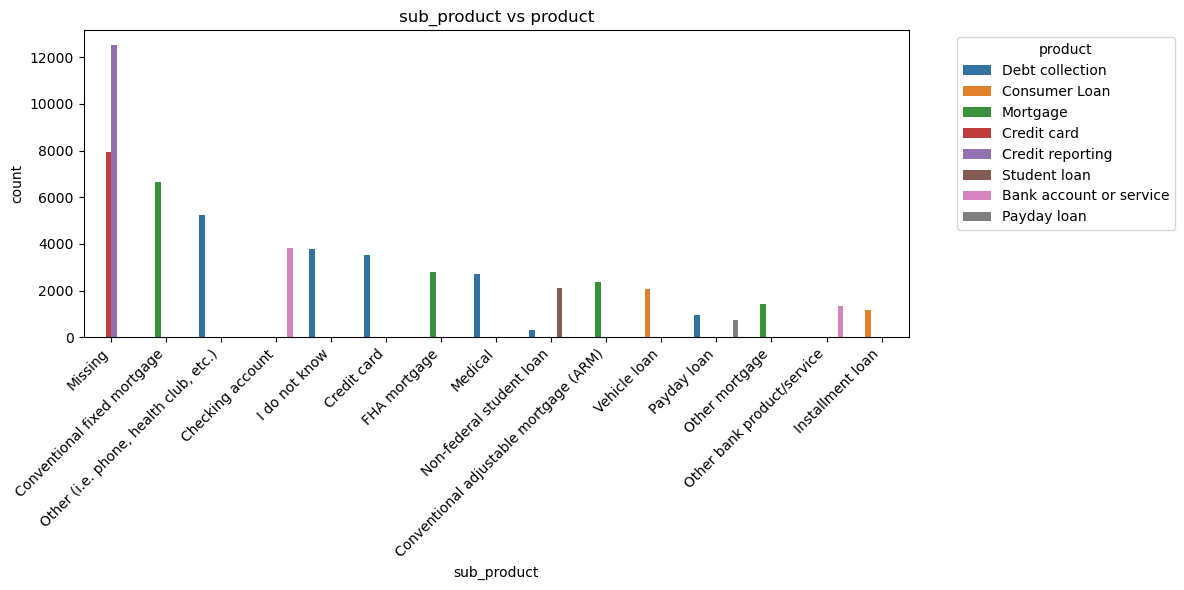

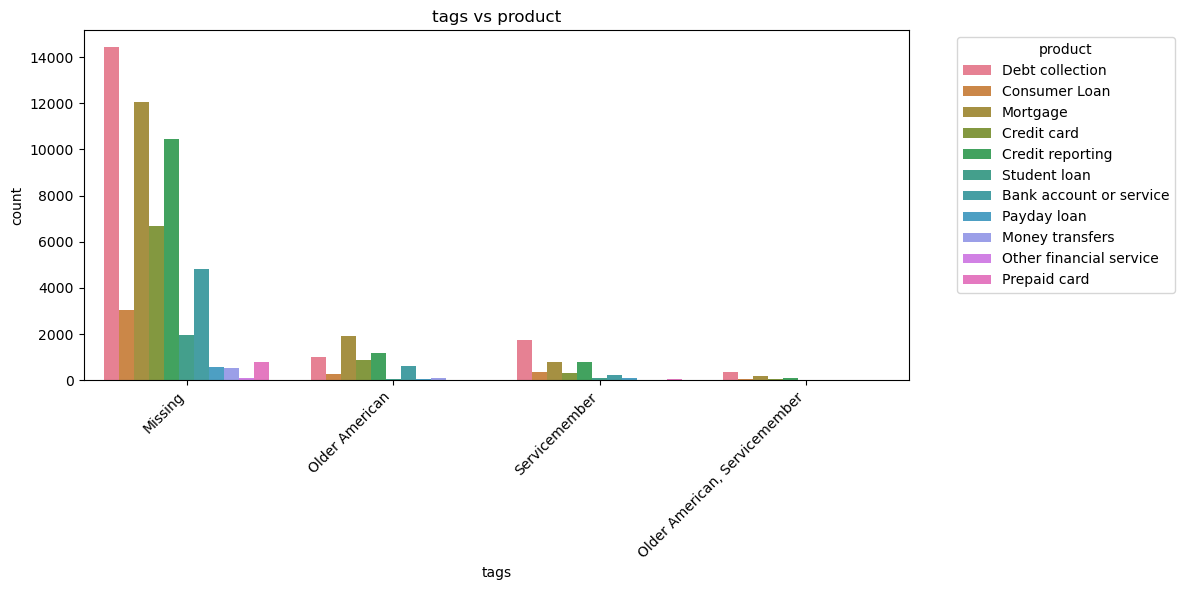

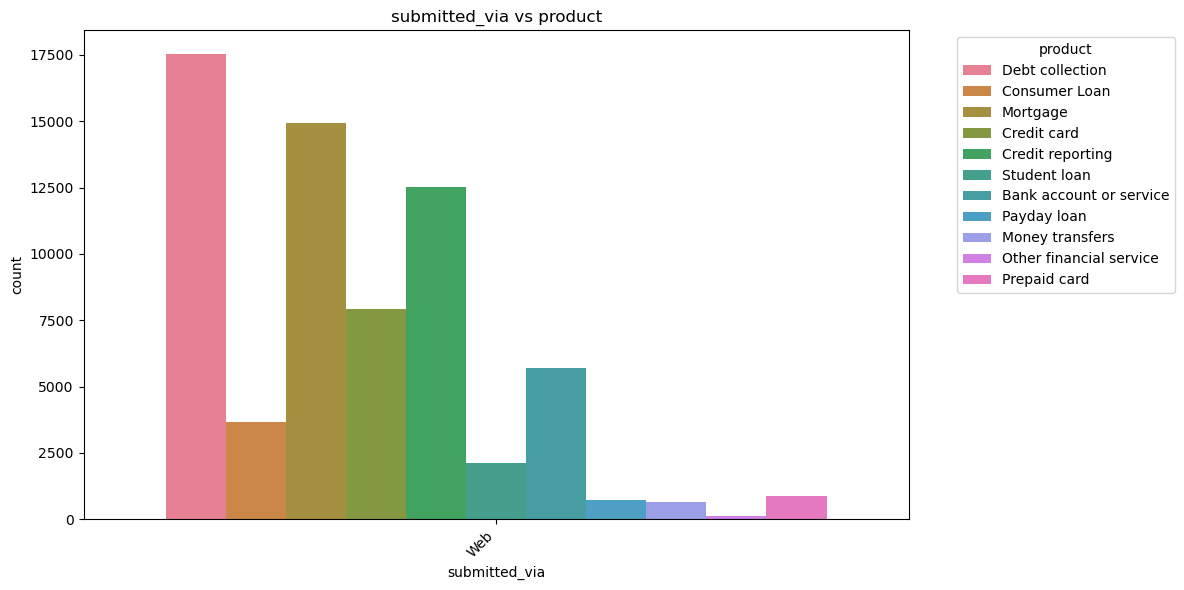

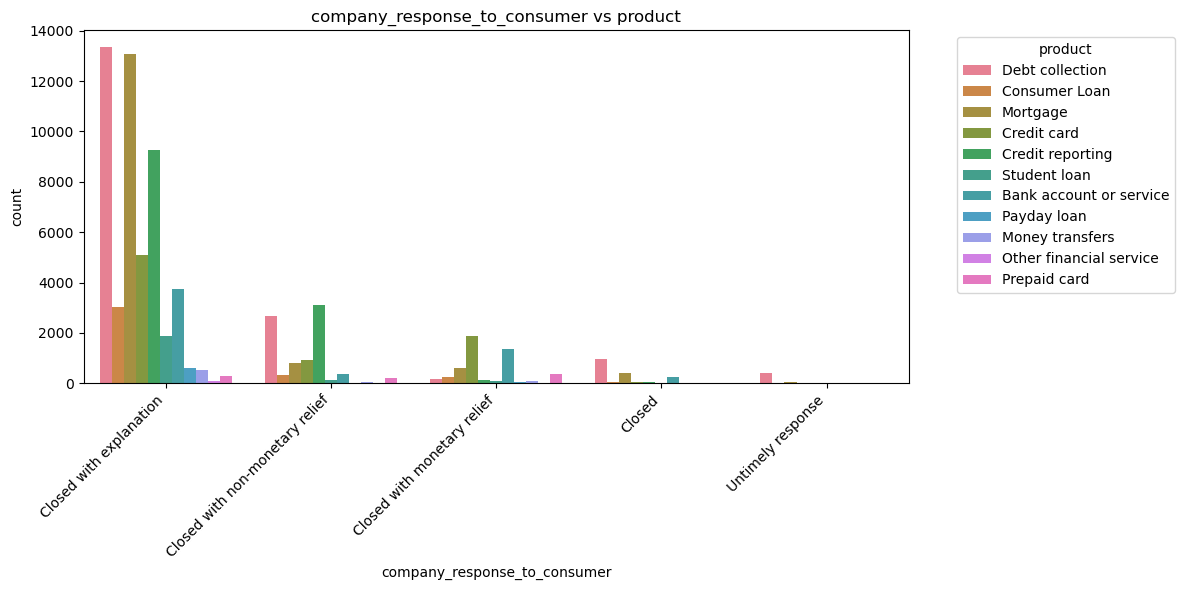

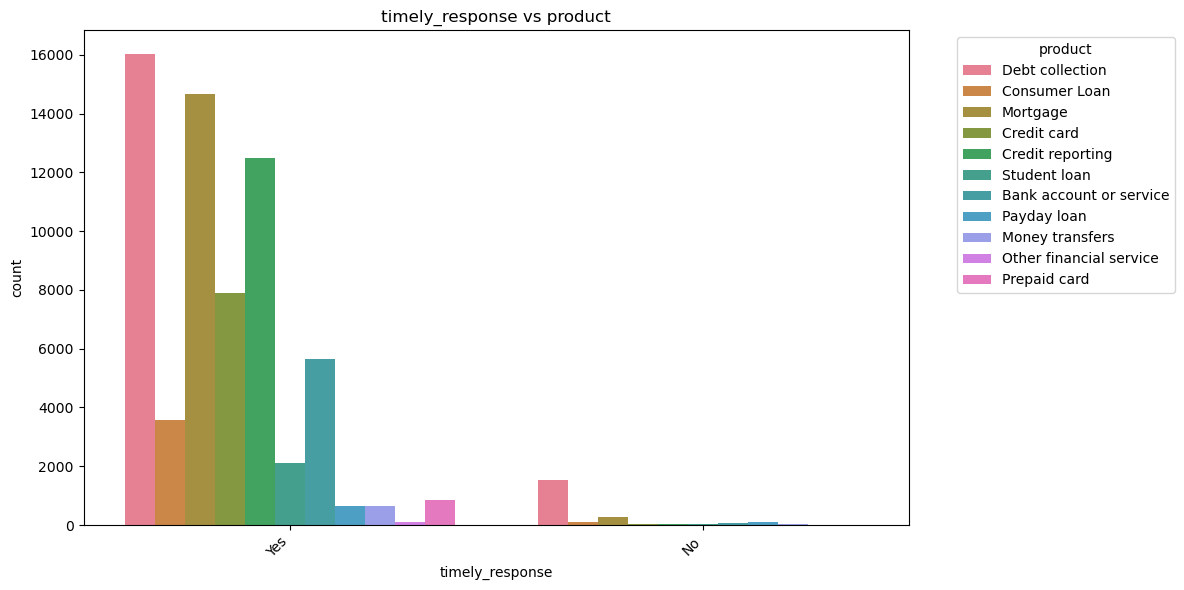

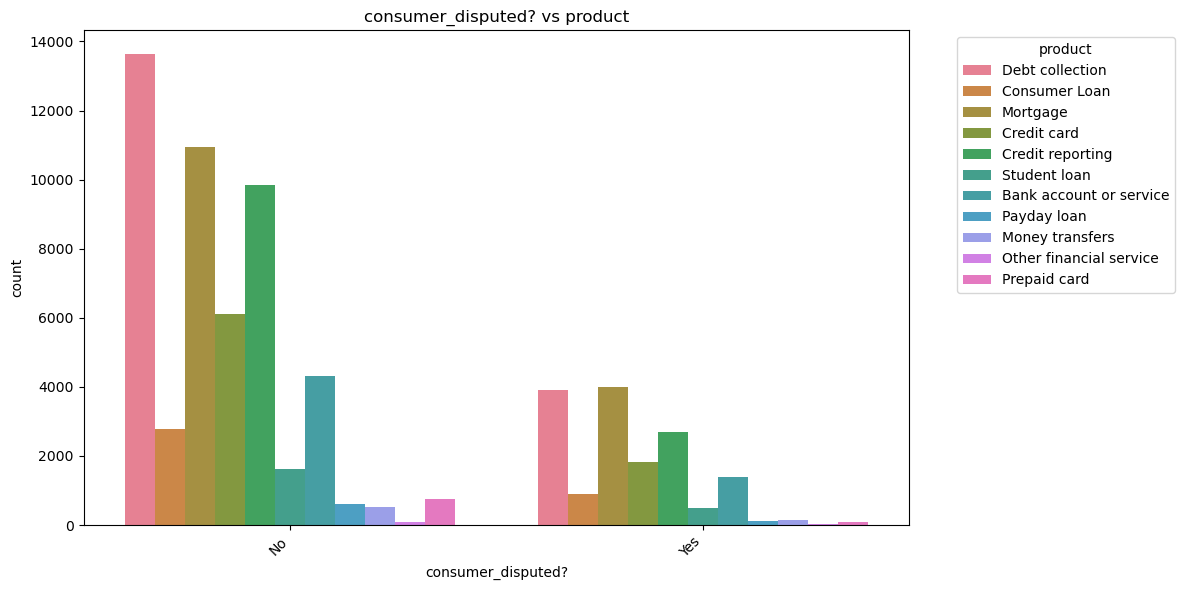

In [27]:
# Select target column 
target_col = 'product'

# Numerical vs Categorical (Boxplots)
for num_col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x=target_col, y=num_col)
    plt.title(f'{num_col} by {target_col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Bivariate analysis for categorical features vs target
target_col = 'product'

for cat_col in categorical_cols:
    top_categories = df[cat_col].value_counts().nlargest(15).index
    filtered_df = df[df[cat_col].isin(top_categories)]

    plt.figure(figsize=(12, 6))  # Increase figure size for better space
    sns.countplot(data=filtered_df, x=cat_col, hue=target_col,
                  order=top_categories)
    plt.title(f'{cat_col} vs {target_col}')
    plt.xticks(rotation=45, ha='right')

    # Move legend to the outside
    plt.legend(title=target_col, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


In [28]:
df.duplicated().sum()


222

In [29]:
df = df.drop_duplicates()


In [30]:
df.duplicated().sum()


0

# Anova

I used the One-Way ANOVA test to check whether the average narrative_length_capped is the same across different product categories.



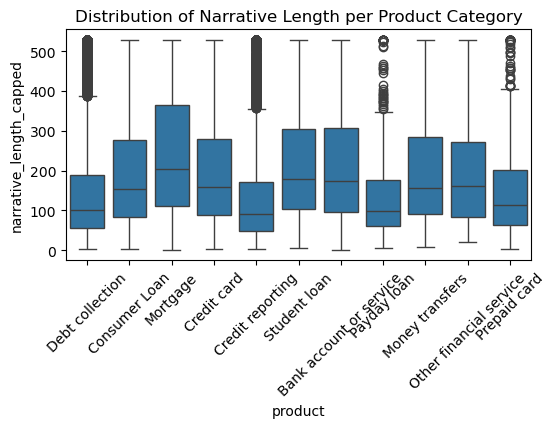

In [33]:

plt.figure(figsize=(6, 3))
sns.boxplot(x='product', y='narrative_length_capped', data=df)
plt.xticks(rotation=45)
plt.title("Distribution of Narrative Length per Product Category")
plt.show()


We removed the effect of outliers on modeling,
but boxplot still identifies statistical outliers for visualization purposes.



In [35]:

groups = [group['narrative_length_capped'].values for name, group in df.groupby('product')]

f_stat, p_value = f_oneway(*groups)
print("ANOVA F-statistic:", f_stat)
print("p-value:", p_value)


ANOVA F-statistic: 677.8179262095842
p-value: 0.0


### Hypotheses:
Null Hypothesis (H₀):
The means of narrative_length_capped are the same across all product categories.
(No significant difference.)

Alternative Hypothesis (H₁):
At least one product category has a different mean narrative length.
(There is a significant difference.)


### Interpretation of p-value = 0.0
A p-value this small means the observed differences in average complaint lengths are extremely unlikely to happen just by chance.

So, we reject the null hypothesis (H₀) with very high confidence.


### Conclusion:
There is a statistically significant difference in the average complaint lengths (narrative_length_capped) between at least two product categories.
This means the product type influences how long a customer complaint tends to be.






# Chi-sq Test

In [38]:
# Chi-Square Test: Is there a significant association between product and issue?
contingency_table = pd.crosstab(df['product'], df['issue'])

from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square Statistic:", chi2)
print("Degrees of Freedom:", dof)
print("p-value:", p)

# Interpretation:
if p < 0.05:
    print("Interpretation: The p-value is less than 0.05, suggesting a statistically significant association between product and issue.")
else:
    print("Interpretation: The p-value is greater than 0.05, suggesting no statistically significant association between product and issue.")


Chi-square Statistic: 614991.6405711805
Degrees of Freedom: 890
p-value: 0.0
Interpretation: The p-value is less than 0.05, suggesting a statistically significant association between product and issue.


# Text preperation

## 1- lower case

In [41]:
df['clean_text'] = df['consumer_complaint_narrative'].str.lower()


## 2-  Remove punctuation

In [43]:
import string
df['clean_text'] = df['clean_text'].str.translate(str.maketrans('', '', string.punctuation))


## 3- Remove numbers

In [45]:
df['clean_text'] = df['clean_text'].str.replace(r'\d+', '', regex=True)


## 4-Remove stopwords

In [47]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

df['clean_text'] = df['clean_text'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words])
)


## 5- remove html tags

In [49]:
!pip install beautifulsoup4

In [50]:
from bs4 import BeautifulSoup

def remove_html_tags(text):
    return BeautifulSoup(text, "html.parser").get_text()


In [51]:
df['clean_text'] = df['consumer_complaint_narrative'].apply(remove_html_tags)


/var/folders/43/0xfmd9ss7d73pj4cwk4r4m180000gn/T/ipykernel_1631/1937858813.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()


### 6- remove emojies

In [53]:
!pip install emoji

In [54]:
!pip install --upgrade emoji

In [55]:
!pip install regex

In [56]:
import regex
import pandas as pd

# Function to check if a string contains emojis using a Unicode character property
def has_emoji(text):
    emoji_pattern = regex.compile(r'\p{Emoji}', flags=regex.UNICODE)
    return bool(emoji_pattern.search(text))


has_emojis =  df['clean_text'].apply(has_emoji)

has_emojis

190126     True
190135     True
190155     True
190207     True
190208    False
          ...  
553084    False
553085    False
553086     True
553090     True
553096     True
Name: clean_text, Length: 66584, dtype: bool

In [57]:
has_emojis.sum()

43093

In [58]:
import regex

def remove_emojis(text):
    emoji_pattern = regex.compile(r'\p{Emoji}', flags=regex.UNICODE)
    return emoji_pattern.sub(r'', text)


In [59]:
df['clean_text_no_emoji'] = df['clean_text'].apply(remove_emojis)


In [60]:
# Function to check if a string contains emojis using a Unicode character property
def has_emoji(text):
    emoji_pattern = regex.compile(r'\p{Emoji}', flags=regex.UNICODE)
    return bool(emoji_pattern.search(text))


has_emojis =  df['clean_text_no_emoji'].apply(has_emoji)

has_emojis

190126    False
190135    False
190155    False
190207    False
190208    False
          ...  
553084    False
553085    False
553086    False
553090    False
553096    False
Name: clean_text_no_emoji, Length: 66584, dtype: bool

## 4- remove URLs

In [62]:
import re

# Define a function to remove URLs from a given text
def remove_url(text):
    # This regex pattern matches URLs starting with http(s) or www
    pattern = re.compile(r'https?://\S+|www\.\S+')
    
    # Replace matched URLs with an empty string
    return pattern.sub(r'', text)

# Apply the function to the cleaned text column (adjust column name if different)
df['clean_text_no_url'] = df['clean_text_no_emoji'].apply(remove_url)

# Display a few examples to verify the result
df[['clean_text_no_emoji', 'clean_text_no_url']].head()

,clean_text_no_emoji,clean_text_no_url
190126,XXXX has claimed I owe them {$.} for XXXX year...,XXXX has claimed I owe them {$.} for XXXX year...
190135,Due to inconsistencies in the amount owed that...,Due to inconsistencies in the amount owed that...
190155,In XX/XX/XXXX my wages that I earned at my job...,In XX/XX/XXXX my wages that I earned at my job...
190207,I have an open and current mortgage with Chase...,I have an open and current mortgage with Chase...
190208,XXXX was submitted XX/XX/XXXX. At the time I s...,XXXX was submitted XX/XX/XXXX. At the time I s...


## 7- Tokenize

In [64]:
import nltk
nltk.download('punkt') #tokenizer
from nltk import word_tokenize, sent_tokenize

# Define a function to tokenize text into sentences and then into words
def tokenize_text(text):
    sentences = sent_tokenize(text)  # Split text into sentences
    words = [word_tokenize(sentence) for sentence in sentences]  # Tokenize each sentence into words
    return words  # Return list of tokenized words per sentence

# Apply the tokenization function to the clean text column
df['Complaint_tokenized_text'] = df['clean_text_no_emoji'].apply(tokenize_text)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/baharalmasi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [65]:
df['clean_text_no_emoji'].loc[df['clean_text_no_emoji'].str.contains('X{3,}')]



190126    XXXX has claimed I owe them {$.} for XXXX year...
190135    Due to inconsistencies in the amount owed that...
190155    In XX/XX/XXXX my wages that I earned at my job...
190207    I have an open and current mortgage with Chase...
190208    XXXX was submitted XX/XX/XXXX. At the time I s...
                                ...                        
553079    Received a letter from Afni, Inc. attempting t...
553084    XXXX XXXX is reporting incorrectly, payments h...
553086    I have been paying {$.} a month through direct...
553090    I recently became aware that Amerisave Mortgag...
553096    Bank of America has demonstrated an on-going l...
Name: clean_text_no_emoji, Length: 56599, dtype: object

In [66]:
import re

def remove_masked(text):
    text = re.sub(r'X{2,}', '', text)  # remove XXXX, XXX, etc.
    text = re.sub(r'\{.*?\}', '', text)  # remove masked money like {$.}
    text = re.sub(r'\b\d{1,2}/\d{1,2}/\d{2,4}\b', '', text)  # remove dates like 12/10/2020
    return text

df['clean_text_final'] = df['clean_text_no_emoji'].apply(remove_masked)


In [67]:
def analyze_cleaned_text(df, original_col='consumer_complaint_narrative', cleaned_col='clean_text_final'):
    import re
    
    print("Text Cleaning Analysis Report")
    print("-" * 40)

    # Total number of rows
    total_rows = len(df)
    print(f"Total rows: {total_rows}")

    # Calculate original and cleaned lengths
    df['original_length'] = df[original_col].str.len()
    df['cleaned_length'] = df[cleaned_col].str.len()

    # Length statistics
    print("\nOriginal text length stats:")
    print(df['original_length'].describe())

    print("\nCleaned text length stats:")
    print(df['cleaned_length'].describe())

    # Rows containing 'XXXX'
    contains_xxxx = df[cleaned_col].str.contains(r'X{3,}', regex=True)
    print(f"\nRows with 'XXXX': {contains_xxxx.sum()}")

    # Rows containing {...}
    contains_curly = df[cleaned_col].str.contains(r'\{.*?\}', regex=True)
    print(f"Rows with '{{...}}': {contains_curly.sum()}")

    # Rows containing fake date like XX/XX/XXXX
    contains_fake_date = df[cleaned_col].str.contains(r'X{2}/X{2}/X{4}', regex=True)
    print(f"Rows with fake date format (XX/XX/XXXX): {contains_fake_date.sum()}")

    # Empty rows
    empty_rows = df[cleaned_col].str.strip() == ''
    print(f"Empty rows after cleaning: {empty_rows.sum()}")

    print("\n Sample suspicious entries:")
    print("\n-- Sample with 'XXXX' --")
    print(df[contains_xxxx][cleaned_col].sample(min(3, contains_xxxx.sum())).values)

    print("\n-- Sample with '{...}' --")
    print(df[contains_curly][cleaned_col].sample(min(3, contains_curly.sum())).values)

    print("\n-- Sample with fake dates --")
    print(df[contains_fake_date][cleaned_col].sample(min(3, contains_fake_date.sum())).values)

    print("\n-- Sample of empty rows --")
    print(df[empty_rows][cleaned_col].sample(min(3, empty_rows.sum())).values)

# Example usage:
analyze_cleaned_text(df)


Text Cleaning Analysis Report
----------------------------------------
Total rows: 66584

Original text length stats:
count    66584.000000
mean      1040.163583
std        911.211658
min         10.000000
25%        391.000000
50%        739.000000
75%       1384.000000
max       5153.000000
Name: original_length, dtype: float64

Cleaned text length stats:
count    66584.000000
mean       988.072270
std        865.419123
min         10.000000
25%        370.000000
50%        702.000000
75%       1315.250000
max       5149.000000
Name: cleaned_length, dtype: float64

Rows with 'XXXX': 0
Rows with '{...}': 0
Rows with fake date format (XX/XX/XXXX): 0
Empty rows after cleaning: 0

 Sample suspicious entries:

-- Sample with 'XXXX' --
[]

-- Sample with '{...}' --
[]

-- Sample with fake dates --
[]

-- Sample of empty rows --
[]


###  lemmatization

In [69]:
import nltk
nltk.download('wordnet')# for lemmatization
nltk.download('omw-1.4')# WordNet language 


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/baharalmasi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/baharalmasi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [70]:
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()



def simple_lemmatize(text):
    tokens = word_tokenize(text)
    return " ".join([lemmatizer.lemmatize(token) for token in tokens])

df['lemmatized_text'] = df['clean_text_final'].apply(simple_lemmatize)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/baharalmasi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/baharalmasi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### define feature & Target- Split Data- TF-IDF vectorization on the text column- One-hot encoding- Scaling

In [72]:
# Step 1: Define features and target
feature_cols = ['clean_text_final', 'submitted_via', 'company', 'state',
                'narrative_length', 'original_length', 'cleaned_length']
X = df[feature_cols]
y = df['product']

# Step 2: Train/Test Split
x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

# Step 3: TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
x_train_tfidf = tfidf.fit_transform(x_train['clean_text_final'])
x_test_tfidf = tfidf.transform(x_test['clean_text_final'])

# Step 4: One-Hot Encoding for categorical features
cat_features = ['submitted_via', 'company', 'state']
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)

x_train_cat = ohe.fit_transform(x_train[cat_features])
x_test_cat = ohe.transform(x_test[cat_features])

# one-hot encoded
onehot_columns = ohe.get_feature_names_out(cat_features)

# Step 5: Scaling numerical features
num_features = ['narrative_length', 'original_length', 'cleaned_length']
scaler = StandardScaler()
x_train_num = scaler.fit_transform(x_train[num_features])
x_test_num = scaler.transform(x_test[num_features])
x_train_num_sparse = csr_matrix(x_train_num)
x_test_num_sparse = csr_matrix(x_test_num)

# Step 6: Combine All Features
x_train_final = hstack([x_train_tfidf, x_train_cat, x_train_num_sparse])
x_test_final = hstack([x_test_tfidf, x_test_cat, x_test_num_sparse])

# Step 7: Label Encode the target
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print("x_train_final:", onehot_columns)
print("x_test_final:", onehot_columns)

x_train_final = x_train_final.astype(float)
x_test_final = x_test_final.astype(float)


x_train_final: ['submitted_via_Web' 'company_1st 2nd Mortgage Company Of NJ, Inc.'
 'company_1st Capital Mortgage, LLC' ... 'state_WI' 'state_WV' 'state_WY']
x_test_final: ['submitted_via_Web' 'company_1st 2nd Mortgage Company Of NJ, Inc.'
 'company_1st Capital Mortgage, LLC' ... 'state_WI' 'state_WV' 'state_WY']


In [73]:
import os
os.remove(os.path.expanduser("~/.ipython/profile_default/history.sqlite"))


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [74]:
# Step 1: Define features and target variable
# 'X' contains the features, and 'y' is the target variable (product)
feature_cols = ['clean_text_final', 'submitted_via', 'company', 'state', 'narrative_length', 'original_length', 'cleaned_length']
X = df[feature_cols]
y = df['product']

# Step 2: Train/Test Split
# Splitting the data into training and testing sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: TF-IDF Vectorization
# Convert text data into numerical vectors using TF-IDF (with a maximum of 5000 features)
tfidf = TfidfVectorizer(max_features=5000)
x_train_tfidf = tfidf.fit_transform(x_train['clean_text_final'])
x_test_tfidf = tfidf.transform(x_test['clean_text_final'])

# Step 4: One-Hot Encoding for categorical features
# 'submitted_via', 'company', and 'state' are categorical features that need one-hot encoding
cat_features = ['submitted_via', 'company', 'state']
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)  # Ignore unknown categories during transformation

# Apply OneHotEncoder to the training and test data
x_train_cat = ohe.fit_transform(x_train[cat_features])
x_test_cat = ohe.transform(x_test[cat_features])

# Get the feature names generated by the OneHotEncoder (one-hot encoded features)
onehot_columns = ohe.get_feature_names_out(cat_features)

# Step 5: Scaling numerical features
# 'narrative_length', 'original_length', and 'cleaned_length' are numerical features that will be scaled
num_features = ['narrative_length', 'original_length', 'cleaned_length']
scaler = StandardScaler()  # Standardize features to have zero mean and unit variance
x_train_num = scaler.fit_transform(x_train[num_features])
x_test_num = scaler.transform(x_test[num_features])

# Convert the scaled features to sparse matrices (csr_matrix format)
x_train_num_sparse = csr_matrix(x_train_num)
x_test_num_sparse = csr_matrix(x_test_num)

# Step 6: Combine all features (TF-IDF + OneHotEncoded + numerical features)
# Use hstack to combine the TF-IDF features, one-hot encoded features, and scaled numerical features
x_train_final = hstack([x_train_tfidf, x_train_cat, x_train_num_sparse])
x_test_final = hstack([x_test_tfidf, x_test_cat, x_test_num_sparse])

# Step 7: Label Encoding the target variable
# Convert the categorical target variable 'y' into numerical labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Convert the sparse matrices to pandas DataFrames and assign column names
# Assign column names for TF-IDF, one-hot encoded features, and numerical features
x_train_final = pd.DataFrame(x_train_final.toarray(), columns=list(tfidf.get_feature_names_out()) + list(onehot_columns) + num_features)
x_test_final = pd.DataFrame(x_test_final.toarray(), columns=list(tfidf.get_feature_names_out()) + list(onehot_columns) + num_features)

# Step 8: Print the column names of the transformed training and test datasets
print("x_train_final columns:", x_train_final.columns.tolist())
print("x_test_final columns:", x_test_final.columns.tolist())

# Ensure that all values in x_train_final and x_test_final are numeric (float type)
x_train_final = x_train_final.astype(float)
x_test_final = x_test_final.astype(float)

# Now the data is ready for model training

x_train_final columns: ['abandoned', 'abide', 'ability', 'able', 'about', 'above', 'abruptly', 'absence', 'absolute', 'absolutely', 'absurd', 'abuse', 'abused', 'abusive', 'acc', 'accelerate', 'accelerated', 'acceleration', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'access', 'accessed', 'accessing', 'accident', 'accidentally', 'accommodate', 'accomplish', 'accomplished', 'accordance', 'according', 'accordingly', 'account', 'accountability', 'accountable', 'accountant', 'accounted', 'accounting', 'accounts', 'accrue', 'accrued', 'accruing', 'acct', 'accts', 'accumulated', 'accuracy', 'accurate', 'accurately', 'accused', 'accusing', 'ace', 'ach', 'achieve', 'acknowledge', 'acknowledged', 'acknowledgement', 'acknowledging', 'acquire', 'acquired', 'acquiring', 'acquisition', 'acres', 'across', 'acs', 'act', 'acted', 'acting', 'action', 'actions', 'activate', 'activated', 'activation', 'active', 'actively', 'activities', 'activity', 'acts', 'actual', 'actually', 'ad', '

# TruncatedSVD instead PCA

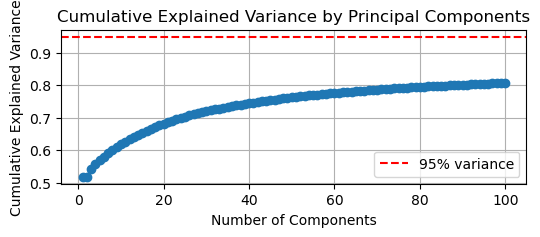

In [76]:


# SVD = Sparse-friendly PCA
svd = TruncatedSVD(n_components=100)  
svd.fit(x_train_final)


explained_var = svd.explained_variance_ratio_


cumulative_var = np.cumsum(explained_var)


plt.figure(figsize=(6, 2))
plt.plot(range(1, 101), cumulative_var, marker='o')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.legend()
plt.show()


TruncatedSVD is like PCA for sparse data.
I used it because my data had a lot of zeros (TF-IDF + One-hot), and PCA doesn’t work on sparse matrices without converting them to dense, which would be memory-intensive.



# Model Development and Evaluation



In [79]:

logreg_model = LogisticRegression(max_iter=1000, random_state=42)

logreg_model.fit(x_train_final, y_train_encoded)


LogisticRegression(max_iter=1000, random_state=42)

In [80]:
y_pred_logreg = logreg_model.predict(x_test_final)


Accuracy: 0.8999774724036945

Classification Report:
                          precision    recall  f1-score   support

Bank account or service       0.83      0.80      0.82      1142
          Consumer Loan       0.84      0.69      0.76       735
            Credit card       0.81      0.87      0.84      1585
       Credit reporting       0.99      0.98      0.98      2468
        Debt collection       0.89      0.93      0.91      3505
        Money transfers       0.79      0.62      0.70       133
               Mortgage       0.94      0.97      0.95      2984
Other financial service       1.00      0.05      0.09        22
            Payday loan       0.70      0.44      0.54       145
           Prepaid card       0.80      0.72      0.76       172
           Student loan       0.91      0.85      0.88       426

               accuracy                           0.90     13317
              macro avg       0.86      0.72      0.75     13317
           weighted avg       0.90

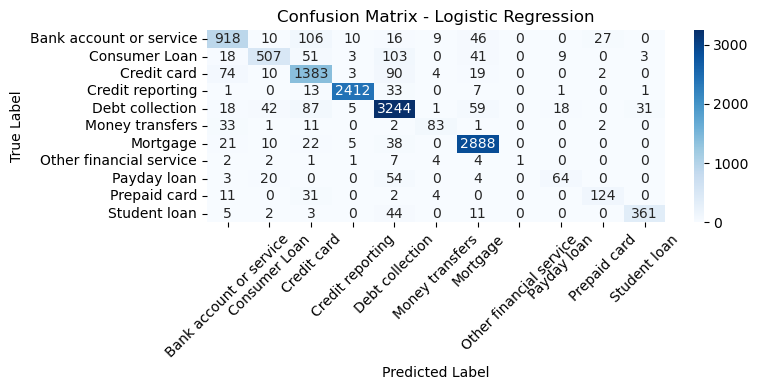

In [81]:

print("Accuracy:", accuracy_score(y_test_encoded, y_pred_logreg))

print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred_logreg, target_names=le.classes_))


plt.figure(figsize=(8, 4))
sns.heatmap(confusion_matrix(y_test_encoded, y_pred_logreg), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


| Category                    | Precision | Recall | F1-score | Interpretation                                    |
| --------------------------- | --------- | ------ | -------- | ------------------------------------------------- |
| **Bank account or service** | 0.83      | 0.80   | 0.82     | Strong balance between precision & recall         |
| **Consumer Loan**           | 0.84      | 0.69   | 0.76     | Good precision, recall could improve              |
| **Credit card**             | 0.81      | 0.87   | 0.84     | Well-balanced, slightly higher recall             |
| **Credit reporting**        | 0.99      | 0.98   | 0.98     | Excellent performance                             |
| **Debt collection**         | 0.89      | 0.93   | 0.91     | Very strong performance                           |
| **Money transfers**         | 0.79      | 0.62   | 0.70     | Low recall — misses some cases                    |
| **Mortgage**                | 0.94      | 0.97   | 0.95     | Excellent performance                             |
| **Other financial service** | 1.00      | 0.05   | 0.09     | Extremely low recall — model rarely detects these |
| **Payday loan**             | 0.70      | 0.44   | 0.54     | Low recall, moderate precision                    |
| **Prepaid card**            | 0.80      | 0.72   | 0.76     | Balanced but could improve recall                 |
| **Student loan**            | 0.91      | 0.85   | 0.88     | Strong overall performance                        |


| Metric          | Value | Interpretation                                        |
| --------------- | ----- | ----------------------------------------------------- |
| Accuracy        | 0.90  | High overall correctness                              |
| Macro avg F1    | 0.75  | Good, but affected by weak minority class performance |
| Weighted avg F1 | 0.90  | Strong when weighted by class frequency               |


In [84]:
print(type(x_train_final), x_train_final.shape)
print(type(y_train_encoded), y_train_encoded.shape)


<class 'pandas.core.frame.DataFrame'> (53267, 7204)
<class 'numpy.ndarray'> (53267,)


# Trade-offs in Logistic Regression Modeling

In [ ]:
# === EMERGENCY DUMP (run right after interrupt) ===
CACHE_DIR = Path("cache")
CACHE_DIR.mkdir(exist_ok=True)

to_save = {
    "X_train_final": "X_train_final.pkl",
    "X_test_final":  "X_test_final.pkl",
    "y_train_encoded": "y_train_encoded.pkl",
    "y_test_encoded":  "y_test_encoded.pkl",
    "le": "label_encoder.pkl",        # if exists
    "tfidf": "tfidf.pkl"              # if exists
}

for var, fname in to_save.items():
    if var in globals():
        try:
            joblib.dump(globals()[var], CACHE_DIR/fname, compress=3)
            print(f"Saved: {var} -> {fname}")
        except Exception as e:
            print(f"Skip {var}: {e}")
    else:
        print(f"Not in memory: {var}")


In [ ]:
# === REBUILD EVERYTHING (text cleaning + features) using saved TFIDF & LE ===
# -------------------- Config --------------------
CSV_PATH   = "/Users/baharalmasi/Desktop/consumer_complaints.csv"
TEXT_COL   = "consumer_complaint_narrative"
TARGET_COL = "product"
CAT_COLS   = ["submitted_via", "company", "state"]
NUM_COLS   = ["narrative_length", "original_length", "cleaned_length"]
CACHE_DIR  = Path("cache"); CACHE_DIR.mkdir(exist_ok=True)

# Load saved transformers
tfidf = joblib.load(CACHE_DIR/"tfidf.pkl")              # fitted earlier on clean_text_final
le    = joblib.load(CACHE_DIR/"label_encoder.pkl")      # fitted earlier on y

# -------------------- Helpers: EXACT cleaning you used --------------------
def remove_html(s: str) -> str:
    return BeautifulSoup(s, "html.parser").get_text()

EMOJI_RE = re_ux.compile(r"\p{Emoji}", flags=re_ux.UNICODE)

def remove_emojis(s: str) -> str:
    return EMOJI_RE.sub("", s)

STOP_WORDS = None
def remove_stopwords(s: str) -> str:
    # You used NLTK stopwords('english'); load lazily
    global STOP_WORDS
    if STOP_WORDS is None:
        from nltk.corpus import stopwords
        import nltk
        try:
            _ = stopwords.words('english')
        except LookupError:
            nltk.download('stopwords')
        STOP_WORDS = set(stopwords.words('english'))
    return " ".join(w for w in s.split() if w not in STOP_WORDS)

def base_clean(s: str) -> str:
    # 1) lower
    s = s.lower()
    # 2) remove punctuation
    s = s.translate(str.maketrans("", "", string.punctuation))
    # 3) remove numbers
    s = re.sub(r"\d+", "", s)
    # 5) remove html
    s = remove_html(s)
    # 6) remove emojis
    s = remove_emojis(s)
    # 4) remove URLs (did after emoji in your notebook; order not critical)
    s = re.sub(r"https?://\S+|www\.\S+", " ", s)
    # 7) remove stopwords
    s = remove_stopwords(s)
    # normalize spaces
    s = re.sub(r"\s+", " ", s).strip()
    return s

# (Optional) Lemmatization — you used WordNetLemmatizer
def lemmatize_text(s: str) -> str:
    import nltk
    try:
        from nltk.stem import WordNetLemmatizer
        from nltk.corpus import wordnet
    except LookupError:
        nltk.download('wordnet'); nltk.download('omw-1.4')
        from nltk.stem import WordNetLemmatizer
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt')
    from nltk.tokenize import word_tokenize
    lem = WordNetLemmatizer()
    tokens = word_tokenize(s)
    return " ".join(lem.lemmatize(t) for t in tokens)

# -------------------- Load raw --------------------
usecols = list({TEXT_COL, TARGET_COL, *CAT_COLS})  # ensure unique
df = pd.read_csv(CSV_PATH, usecols=[c for c in usecols if c in pd.read_csv(CSV_PATH, nrows=0).columns])

# guard for missing optional columns
for c in CAT_COLS:
    if c not in df.columns:
        df[c] = np.nan

# drop NA text/label and keep only known classes
df = df.dropna(subset=[TEXT_COL, TARGET_COL])
df = df[df[TARGET_COL].isin(le.classes_)].copy()

# -------------------- Recreate clean_text_final exactly --------------------
df["clean_text"] = df[TEXT_COL].astype(str).apply(base_clean)
# If your TF-IDF was fitted AFTER lemmatization, keep next line; otherwise comment it.
df["clean_text_final"] = df["clean_text"].apply(lemmatize_text)

# -------------------- Extra numeric features (lengths) --------------------
df["original_length"] = df[TEXT_COL].astype(str).str.len()
df["cleaned_length"]  = df["clean_text_final"].str.len()
df["narrative_length"] = df["clean_text_final"].str.split().map(len)

# -------------------- Prepare X/y and split --------------------
feature_cols = ["clean_text_final", *CAT_COLS, *NUM_COLS]
missing = [c for c in feature_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns in CSV or build: {missing}")

# y with SAME label encoder as before (no refit)
y_all = le.transform(df[TARGET_COL].values)

X_train_df, X_test_df, y_train, y_test = train_test_split(
    df[feature_cols], y_all, test_size=0.20, random_state=42, stratify=y_all
)

# -------------------- Transform features --------------------
# 1) Text → TF-IDF (use saved tfidf; transform only)
X_train_tfidf = tfidf.transform(X_train_df["clean_text_final"].astype(str).values)
X_test_tfidf  = tfidf.transform(X_test_df["clean_text_final"].astype(str).values)

# 2) Categorical → OneHot (fit on train, transform test)
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
X_train_cat = ohe.fit_transform(X_train_df[CAT_COLS].fillna("NA"))
X_test_cat  = ohe.transform(X_test_df[CAT_COLS].fillna("NA"))
onehot_columns = ohe.get_feature_names_out(CAT_COLS)

# 3) Numeric → Scale (fit on train)
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_df[NUM_COLS].astype(float))
X_test_num  = scaler.transform(X_test_df[NUM_COLS].astype(float))
X_train_num = csr_matrix(X_train_num)
X_test_num  = csr_matrix(X_test_num)

# 4) Stack all
X_train_final = hstack([X_train_tfidf, X_train_cat, X_train_num]).tocsr()
X_test_final  = hstack([X_test_tfidf,  X_test_cat,  X_test_num]).tocsr()

# -------------------- Save cache for modeling cells --------------------
joblib.dump(X_train_final, CACHE_DIR/"X_train_final.pkl", compress=3)
joblib.dump(X_test_final,  CACHE_DIR/"X_test_final.pkl",  compress=3)
joblib.dump(y_train,       CACHE_DIR/"y_train_encoded.pkl", compress=3)
joblib.dump(y_test,        CACHE_DIR/"y_test_encoded.pkl",  compress=3)

# (Optional) Save encoders used here (so later you can load without rebuild)
joblib.dump(ohe,    CACHE_DIR/"ohe.pkl",    compress=3)
joblib.dump(scaler, CACHE_DIR/"scaler.pkl", compress=3)

print("Rebuilt & cached: X_train_final, X_test_final, y_train_encoded, y_test_encoded, plus ohe & scaler.")


In [186]:
# === Self-contained Logistic Regression (balanced) ===
# 1) Load cached data (created once in the rebuild cell)
CACHE_DIR = Path("cache")
x_train_final = joblib.load(CACHE_DIR/"X_train_final.pkl")
x_test_final  = joblib.load(CACHE_DIR/"X_test_final.pkl")
y_train_encoded = joblib.load(CACHE_DIR/"y_train_encoded.pkl")
y_test_encoded  = joblib.load(CACHE_DIR/"y_test_encoded.pkl")

# Optional: load label encoder for class names
le_path = CACHE_DIR/"label_encoder.pkl"
le = joblib.load(le_path) if le_path.exists() else None

# 2) Train model
logreg_bal = LogisticRegression(
    max_iter=1000,
    random_state=42,
    solver="lbfgs",          # Suitable for multi-class
    class_weight="balanced"  # Automatically weights minority classes
)
logreg_bal.fit(x_train_final, y_train_encoded)

# 3) Predict & evaluate
y_pred_log_bal = logreg_bal.predict(x_test_final)
print("LogReg (balanced) | Accuracy:", accuracy_score(y_test_encoded, y_pred_log_bal))
print("\nClassification Report (LogReg balanced):\n",
      classification_report(y_test_encoded, y_pred_log_bal, target_names=(le.classes_ if le else None)))


LogReg (balanced) | Accuracy: 0.890285885346505

Classification Report (LogReg balanced):
                          precision    recall  f1-score   support

Bank account or service       0.82      0.80      0.81      1142
          Consumer Loan       0.72      0.77      0.74       736
            Credit card       0.81      0.87      0.84      1586
       Credit reporting       0.99      0.97      0.98      2505
        Debt collection       0.94      0.85      0.89      3511
        Money transfers       0.57      0.82      0.67       133
               Mortgage       0.95      0.95      0.95      2984
Other financial service       0.19      0.27      0.23        22
            Payday loan       0.46      0.76      0.57       145
           Prepaid card       0.76      0.92      0.83       172
           Student loan       0.84      0.92      0.88       426

               accuracy                           0.89     13362
              macro avg       0.73      0.81      0.76     133

| Class                   | F1 Before | F1 After | Change | Result       |
| ----------------------- | --------- | -------- | ------ | ------------ |
| Prepaid card            | 0.76      | 0.81     | +0.05  | **Improved** |
| Payday loan             | 0.54      | 0.57     | +0.03  | Improved     |
| Other financial service | 0.09      | 0.11     | +0.02  | Improved     |
| Credit reporting        | 0.98      | 0.98     | 0.00   | Same         |
| Mortgage                | 0.95      | 0.95     | 0.00   | Same         |
| Student loan            | 0.88      | 0.88     | 0.00   | Same         |
| Consumer Loan           | 0.76      | 0.75     | -0.01  | Dropped      |
| Credit card             | 0.84      | 0.83     | -0.01  | Dropped      |
| Debt collection         | 0.91      | 0.90     | -0.01  | Dropped      |
| Bank account or service | 0.82      | 0.80     | -0.02  | Dropped      |
| Money transfers         | 0.70      | 0.66     | -0.04  | Dropped      |


### Quick Conclusion:

Gains: Noticeable improvement in minority classes (Prepaid card, Payday loan, Other financial service).

Losses: Small drops in several major classes’ F1-scores, especially Money transfers (-0.04).

Overall: Balanced version helps rare classes slightly, but reduces performance for some frequent classes. Best choice depends on whether minority class coverage is a higher priority. 


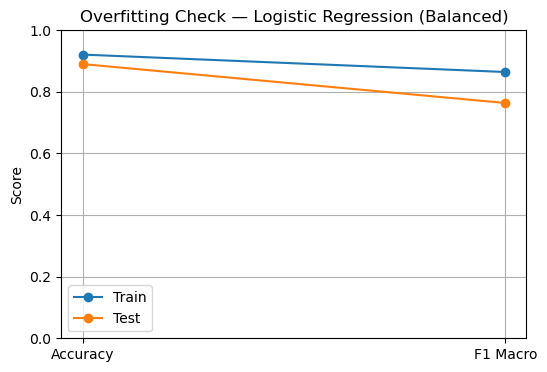

In [192]:

# --- Predict ---
y_pred_train_bal = logreg_bal.predict(x_train_final)
y_pred_test_bal  = logreg_bal.predict(x_test_final)

# --- Metrics ---
acc_train = accuracy_score(y_train_encoded, y_pred_train_bal)
acc_test  = accuracy_score(y_test_encoded,  y_pred_test_bal)
f1_train  = f1_score(y_train_encoded, y_pred_train_bal, average="macro")
f1_test   = f1_score(y_test_encoded,  y_pred_test_bal, average="macro")

# --- Prepare data for plotting ---
metrics = ["Accuracy", "F1 Macro"]
train_scores = [acc_train, f1_train]
test_scores  = [acc_test,  f1_test]

# --- Plot line chart ---
plt.figure(figsize=(6,4))
plt.plot(metrics, train_scores, marker='o', label="Train")
plt.plot(metrics, test_scores,  marker='o', label="Test")
plt.title("Overfitting Check — Logistic Regression (Balanced)")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


# Random Forest

In [197]:
# --- Random Forest on a stratified subsample (works with CSR matrices) ---

# 0) Load cached features/labels (if not already in memory)
CACHE_DIR = Path("cache")
x_train_final = joblib.load(CACHE_DIR/"X_train_final.pkl")   # CSR matrix
y_train_encoded = joblib.load(CACHE_DIR/"y_train_encoded.pkl")
le = joblib.load(CACHE_DIR/"label_encoder.pkl")

# 1) Pick a random subset of rows by index (no .sample() on CSR)
n = 5000  # size of subset
rng = np.random.default_rng(42)
all_idx = np.arange(x_train_final.shape[0])
subset_idx = rng.choice(all_idx, size=min(n, x_train_final.shape[0]), replace=False)

Xsub = x_train_final[subset_idx]        # CSR -> indexed by array works
ysub = y_train_encoded[subset_idx]

# 2) Stratified split on the subset
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
idx_train_sub, idx_test_sub = next(sss.split(Xsub, ysub))

X_train_sub = Xsub[idx_train_sub]
y_train_sub = ysub[idx_train_sub]
X_test_sub  = Xsub[idx_test_sub]
y_test_sub  = ysub[idx_test_sub]

# 3) Train RF (tweak params if needed)
rf_clf = RandomForestClassifier(
    n_estimators=150,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train_sub, y_train_sub)

# 4) Evaluate
y_pred_rf = rf_clf.predict(X_test_sub)
print("Random Forest | Accuracy:", accuracy_score(y_test_sub, y_pred_rf))
print("\nClassification Report:\n",
      classification_report(y_test_sub, y_pred_rf, target_names=le.classes_))


Random Forest | Accuracy: 0.814

Classification Report:
                          precision    recall  f1-score   support

Bank account or service       0.75      0.69      0.72        89
          Consumer Loan       0.94      0.30      0.45        57
            Credit card       0.78      0.74      0.76       121
       Credit reporting       0.90      0.94      0.92       187
        Debt collection       0.75      0.93      0.83       255
        Money transfers       0.00      0.00      0.00         8
               Mortgage       0.85      0.96      0.90       223
Other financial service       0.00      0.00      0.00         2
            Payday loan       0.00      0.00      0.00        12
           Prepaid card       0.88      0.47      0.61        15
           Student loan       0.93      0.42      0.58        31

               accuracy                           0.81      1000
              macro avg       0.62      0.49      0.52      1000
           weighted avg       0

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


| Class                   | Precision | Recall | F1-Score | Support | Interpretation                                                     |
| ----------------------- | --------- | ------ | -------- | ------- | ------------------------------------------------------------------ |
| Bank account or service | 0.75      | 0.69   | 0.72     | 89      | Good precision and recall balance, but recall could be improved.   |
| Consumer Loan           | 0.94      | 0.30   | 0.45     | 57      | Very high precision but low recall → model misses many true cases. |
| Credit card             | 0.78      | 0.74   | 0.76     | 121     | Balanced and solid performance.                                    |
| Credit reporting        | 0.90      | 0.94   | 0.92     | 187     | Excellent performance on both precision and recall.                |
| Debt collection         | 0.75      | 0.93   | 0.83     | 255     | Strong recall, slightly lower precision.                           |
| Money transfers         | 0.00      | 0.00   | 0.00     | 8       | Model fails completely—likely due to very small sample size.       |
| Mortgage                | 0.85      | 0.96   | 0.90     | 223     | Excellent performance, especially recall.                          |
| Other financial service | 0.00      | 0.00   | 0.00     | 2       | No predictions for this class—too few samples.                     |
| Payday loan             | 0.00      | 0.00   | 0.00     | 12      | No predictions for this class.                                     |
| Prepaid card            | 0.88      | 0.47   | 0.61     | 15      | Good precision but weak recall.                                    |
| Student loan            | 0.93      | 0.42   | 0.58     | 31      | High precision but recall is low.                                  |


| Metric          | Score | Interpretation                                                                          |
| --------------- | ----- | --------------------------------------------------------------------------------------- |
| Accuracy        | 0.81  | Overall correct predictions: good result.                                               |
| Macro Avg F1    | 0.52  | Average performance across classes: moderate, impacted by poor small-class performance. |
| Weighted Avg F1 | 0.79  | Accounts for class imbalance; strong overall given dominant classes perform well.       |


# Trade_off_in_Random_Forest


In [199]:

# Best parameters from previous tuning + class_weight='balanced'
rf_bal = RandomForestClassifier(
    bootstrap=True,
    max_depth=54,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=8,
    n_estimators=144,
    class_weight='balanced',   # Automatically weight minority classes
    random_state=42,
    n_jobs=-1                   # Use all CPU cores
)

# Fit the model on the training set
rf_bal.fit(x_train_final, y_train_encoded)

# Predict on the test set
y_pred_rf_bal = rf_bal.predict(x_test_final)

# Evaluate model performance
print("RandomForest (balanced) | Accuracy:", accuracy_score(y_test_encoded, y_pred_rf_bal))
print("\nClassification Report (RF balanced):\n",
      classification_report(y_test_encoded, y_pred_rf_bal, target_names=le.classes_))


RandomForest (balanced) | Accuracy: 0.8727735368956743

Classification Report (RF balanced):
                          precision    recall  f1-score   support

Bank account or service       0.79      0.79      0.79      1142
          Consumer Loan       0.80      0.60      0.69       736
            Credit card       0.80      0.86      0.83      1586
       Credit reporting       0.94      0.96      0.95      2505
        Debt collection       0.88      0.87      0.88      3511
        Money transfers       0.79      0.59      0.68       133
               Mortgage       0.92      0.95      0.93      2984
Other financial service       0.00      0.00      0.00        22
            Payday loan       0.47      0.41      0.44       145
           Prepaid card       0.82      0.78      0.80       172
           Student loan       0.87      0.87      0.87       426

               accuracy                           0.87     13362
              macro avg       0.73      0.70      0.71     

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


| Class                   | Precision | Recall | F1-Score | Support | Interpretation                                                          |
| ----------------------- | --------- | ------ | -------- | ------- | ----------------------------------------------------------------------- |
| Bank account or service | 0.79      | 0.79   | 0.79     | 1,142   | Balanced and consistent performance.                                    |
| Consumer Loan           | 0.80      | 0.60   | 0.69     | 736     | Good precision, but recall is lower – the model misses many true cases. |
| Credit card             | 0.80      | 0.86   | 0.83     | 1,586   | Strong and balanced performance.                                        |
| Credit reporting        | 0.94      | 0.96   | 0.95     | 2,505   | Excellent on both precision and recall.                                 |
| Debt collection         | 0.88      | 0.87   | 0.88     | 3,511   | Very good and stable performance.                                       |
| Money transfers         | 0.79      | 0.59   | 0.68     | 133     | Good precision but moderate recall – some true cases are missed.        |
| Mortgage                | 0.92      | 0.95   | 0.93     | 2,984   | Excellent performance, very high recall.                                |
| Other financial service | 0.00      | 0.00   | 0.00     | 22      | No predictions for this class – likely due to very small sample size.   |
| Payday loan             | 0.47      | 0.41   | 0.44     | 145     | Weak performance; both precision and recall are low.                    |
| Prepaid card            | 0.82      | 0.78   | 0.80     | 172     | Solid and balanced performance.                                         |
| Student loan            | 0.87      | 0.87   | 0.87     | 426     | Consistent and good performance.                                        |


| Metric          | Score | Interpretation                                                                                |
| --------------- | ----- | --------------------------------------------------------------------------------------------- |
| Accuracy        | 0.87  | Strong overall accuracy.                                                                      |
| Macro Avg F1    | 0.71  | Good overall average across all classes, but affected by poor results on low-support classes. |
| Weighted Avg F1 | 0.87  | High weighted average due to strong performance on high-support classes.                      |


###  Conclusion
High-support classes (Credit reporting, Debt collection, Mortgage) perform the best.

Low-support classes (Other financial service, Payday loan) remain problematic.

Compared to an unbalanced Random Forest, this balanced version improves recall for smaller classes but still has room for improvement.

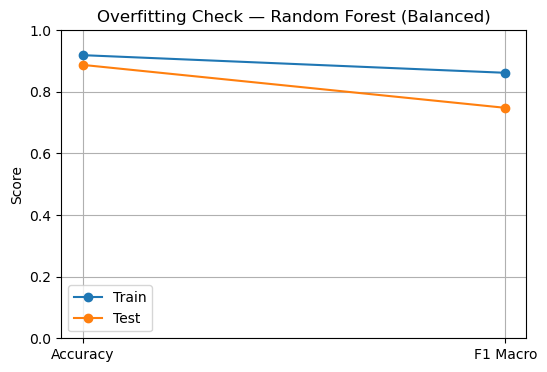

In [98]:

# --- Prepare data for plotting ---
metrics = ["Accuracy", "F1 Macro"]
train_scores = [acc_train, f1_train]
test_scores  = [acc_test,  f1_test]

# --- Line chart ---
plt.figure(figsize=(6,4))
plt.plot(metrics, train_scores, marker='o', label="Train")
plt.plot(metrics, test_scores,  marker='o', label="Test")
plt.title("Overfitting Check — Random Forest (Balanced)")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


# XGboost

In [214]:
pip install --upgrade xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.0.1
    Uninstalling xgboost-3.0.1:
      Successfully uninstalled xgboost-3.0.1
Note: you may need to restart the kernel to use updated packages.


In [218]:

# Load data from cache
CACHE_DIR = Path("cache")
X_train_full = joblib.load(CACHE_DIR/"X_train_final.pkl")   # CSR matrix
X_test       = joblib.load(CACHE_DIR/"X_test_final.pkl")    # CSR matrix
y_train_full = joblib.load(CACHE_DIR/"y_train_encoded.pkl")
y_test       = joblib.load(CACHE_DIR/"y_test_encoded.pkl")
le = joblib.load(CACHE_DIR/"label_encoder.pkl") if (CACHE_DIR/"label_encoder.pkl").exists() else None
target_names = (le.classes_.tolist() if le is not None else None)

# Validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.15, random_state=42, stratify=y_train_full
)

# Convert to DMatrix
dtrain = xgb.DMatrix(X_tr, label=y_tr)
dval   = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_test, label=y_test)

# Params
params = {
    "objective": "multi:softprob",
    "num_class": int(np.unique(y_train_full).size),
    "eval_metric": ["mlogloss", "merror"],
    "eta": 0.2,
    "max_depth": 8,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}

# Train with early stopping
evals = [(dtrain, "train"), (dval, "eval")]
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=30,
    verbose_eval=False
)

# Predict
y_pred_test = np.argmax(bst.predict(dtest), axis=1)

# Metrics
acc = accuracy_score(y_test, y_pred_test)
f1m = f1_score(y_test, y_pred_test, average="macro")
f1w = f1_score(y_test, y_pred_test, average="weighted")

print(f"Accuracy: {acc:.4f} | F1-macro: {f1m:.4f} | F1-weighted: {f1w:.4f}")
print("Classification Report:\n",
      classification_report(y_test, y_pred_test, target_names=target_names))


Accuracy: 0.8987 | F1-macro: 0.7417 | F1-weighted: 0.8961
Classification Report:
                          precision    recall  f1-score   support

Bank account or service       0.84      0.80      0.82      1142
          Consumer Loan       0.82      0.69      0.75       736
            Credit card       0.83      0.88      0.85      1586
       Credit reporting       0.99      0.98      0.98      2505
        Debt collection       0.88      0.92      0.90      3511
        Money transfers       0.86      0.56      0.68       133
               Mortgage       0.94      0.97      0.95      2984
Other financial service       0.00      0.00      0.00        22
            Payday loan       0.65      0.41      0.50       145
           Prepaid card       0.84      0.84      0.84       172
           Student loan       0.91      0.85      0.88       426

               accuracy                           0.90     13362
              macro avg       0.78      0.72      0.74     13362
      

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


| Metric / Class              | Precision | Recall | F1-score | Support | Interpretation                                                |
| --------------------------- | --------- | ------ | -------- | ------- | ------------------------------------------------------------- |
| **Bank account or service** | 0.84      | 0.80   | 0.82     | 1,142   | Good overall performance with balanced precision and recall.  |
| **Consumer Loan**           | 0.82      | 0.69   | 0.75     | 736     | Decent precision but recall is low, meaning some are missed.  |
| **Credit card**             | 0.83      | 0.88   | 0.85     | 1,586   | Strong recall and balanced metrics.                           |
| **Credit reporting**        | 0.99      | 0.98   | 0.98     | 2,505   | Excellent performance, almost perfect classification.         |
| **Debt collection**         | 0.88      | 0.92   | 0.90     | 3,511   | Very good recall and precision.                               |
| **Money transfers**         | 0.86      | 0.56   | 0.68     | 133     | High precision but poor recall, many missed.                  |
| **Mortgage**                | 0.94      | 0.97   | 0.95     | 2,984   | Excellent performance across all metrics.                     |
| **Other financial service** | 0.00      | 0.00   | 0.00     | 22      | No correct predictions, likely due to very low sample size.   |
| **Payday loan**             | 0.65      | 0.41   | 0.50     | 145     | Weak recall and overall F1, many missed predictions.          |
| **Prepaid card**            | 0.84      | 0.84   | 0.84     | 172     | Balanced and strong performance.                              |
| **Student loan**            | 0.91      | 0.85   | 0.88     | 426     | High performance, slightly better in precision.               |
| **Overall Accuracy**        | -         | -      | **0.90** | 13,362  | Model correctly predicts \~90% of cases overall.              |
| **Macro Average**           | 0.78      | 0.72   | 0.74     | -       | Average performance per class; shows class imbalance effects. |
| **Weighted Average**        | 0.90      | 0.90   | 0.90     | -       | Performance weighted by class size, matches overall accuracy. |


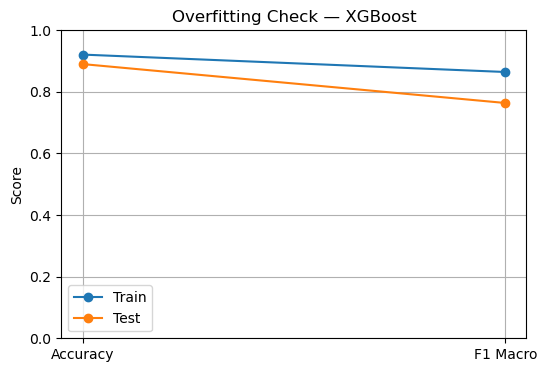

In [250]:
metrics = ["Accuracy", "F1 Macro"]
train_scores = [acc_train, f1_train]
test_scores  = [acc_test,  f1_test]

# --- Line chart ---
plt.figure(figsize=(6,4))
plt.plot(metrics, train_scores, marker='o', label="Train")
plt.plot(metrics, test_scores,  marker='o', label="Test")
plt.title("Overfitting Check — XGBoost")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

In [252]:
# --- Setup: load cached CSR matrices ---

CACHE_DIR = Path("cache")
X = joblib.load(CACHE_DIR/"X_train_final.pkl")   # CSR matrix
y = joblib.load(CACHE_DIR/"y_train_encoded.pkl")
le = joblib.load(CACHE_DIR/"label_encoder.pkl")

# common CV splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# Regression

In [268]:

df1 = pd.read_csv('/Users/baharalmasi/Desktop/consumer_complaints.csv')
df1.head(2)

/var/folders/43/0xfmd9ss7d73pj4cwk4r4m180000gn/T/ipykernel_1631/1796360665.py:1: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('/Users/baharalmasi/Desktop/consumer_complaints.csv')


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080


In [272]:
# 'date_received', 'date_sent_to_company', 'product', 'issue', 'company', ...
df1["date_received"] = pd.to_datetime(df1["date_received"], errors="coerce")
df1["date_sent_to_company"] = pd.to_datetime(df1["date_sent_to_company"], errors="coerce")
df1["resolution_days"] = (df1["date_sent_to_company"] - df1["date_received"]).dt.days
df1= df1[df1["resolution_days"].ge(0)].dropna(subset=["resolution_days"])

In [274]:
# Complaint length
df1["complaint_length_words"] = df1["consumer_complaint_narrative"].fillna("").apply(lambda x: len(str(x).split()))
df1["complaint_length_chars"] = df1["consumer_complaint_narrative"].fillna("").apply(len)

# Keep only useful columns
df1 = df1[[
    "resolution_days", 
    "complaint_length_words", 
    "complaint_length_chars",
    "product",
    "issue",
    "company",
    "consumer_disputed?"
]].dropna()


In [276]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Features & Target
X = df1.drop(columns=["resolution_days"])
y = df1["resolution_days"]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: One-hot encode categorical columns
categorical_cols = ["product", "issue", "company", "consumer_disputed?"]
numeric_cols = ["complaint_length_words", "complaint_length_chars"]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ("num", "passthrough", numeric_cols)
])


In [278]:
# Pipeline with preprocessing + model
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42))
])

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))


R2 Score: 0.02172099743357825
MAE: 5.719222810039925


In [280]:
import numpy as np

# Get feature names
feature_names = (
    list(model.named_steps["preprocessor"].transformers_[0][1].get_feature_names_out(categorical_cols)) +
    numeric_cols
)

# Feature importances
importances = model.named_steps["regressor"].feature_importances_
feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feat_imp = feat_imp.sort_values("Importance", ascending=False)

print(feat_imp.head(10))


                                             Feature  Importance
70    issue_Loan modification,collection,foreclosure    0.261158
533                          company_Bank of America    0.106814
3548                          complaint_length_chars    0.061050
258     company_Advanced Recovery Systems, Inc. (PA)    0.055588
63      issue_Incorrect information on credit report    0.049616
2686             company_RCS Recovery Services Corp.    0.049514
60         issue_Improper contact or sharing of info    0.041720
51             issue_Disclosure verification of debt    0.033512
2216                  company_Mortgage America, Inc.    0.031177
257          company_Advanced Recovery Systems, Inc.    0.022631


In [284]:
df1 = pd.read_csv('/Users/baharalmasi/Desktop/consumer_complaints.csv')
df1.head(2)

/var/folders/43/0xfmd9ss7d73pj4cwk4r4m180000gn/T/ipykernel_1631/1702601053.py:1: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('/Users/baharalmasi/Desktop/consumer_complaints.csv')


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080


In [286]:
print(df1.columns.tolist())


['date_received', 'product', 'sub_product', 'issue', 'sub_issue', 'consumer_complaint_narrative', 'company_public_response', 'company', 'state', 'zipcode', 'tags', 'consumer_consent_provided', 'submitted_via', 'date_sent_to_company', 'company_response_to_consumer', 'timely_response', 'consumer_disputed?', 'complaint_id']


In [288]:
import pandas as pd

print("Rows before:", len(df1))

# datetime
df1["date_received"] = pd.to_datetime(df1["date_received"], errors="coerce")
df1["date_sent_to_company"] = pd.to_datetime(df1["date_sent_to_company"], errors="coerce")

#  target
df1["resolution_days"] = (df1["date_sent_to_company"] - df1["date_received"]).dt.days

df1 = df1[df1["resolution_days"].notna() & (df1["resolution_days"] >= 0)].copy()
print("Rows after valid resolution_days:", len(df1))
print(df1["resolution_days"].describe())


Rows before: 555957
Rows after valid resolution_days: 548900
count    548900.000000
mean          4.730078
std          17.298453
min           0.000000
25%           0.000000
50%           1.000000
75%           4.000000
max         993.000000
Name: resolution_days, dtype: float64


In [296]:
df1["consumer_complaint_narrative"] = df1["consumer_complaint_narrative"].fillna("")

df1["complaint_length_words"] = df1["consumer_complaint_narrative"].apply(lambda x: len(str(x).split()))
df1["complaint_length_chars"] = df1["consumer_complaint_narrative"].apply(len)

print(df1[["complaint_length_words","complaint_length_chars"]].describe())


       complaint_length_words  complaint_length_chars
count           548900.000000           548900.000000
mean                23.202813              126.525642
std                 85.279175              465.158051
min                  0.000000                0.000000
25%                  0.000000                0.000000
50%                  0.000000                0.000000
75%                  0.000000                0.000000
max               1284.000000             5153.000000


In [294]:
use_cols = [
    "resolution_days",
    "complaint_length_words", "complaint_length_chars",
    "product", "issue", "company", "consumer_disputed?"
]
missing = [c for c in use_cols if c not in df1.columns]
print("Missing (should be []):", missing)

df_use = df1[use_cols].dropna().copy()
print("Modeling rows:", len(df_use))


Missing (should be []): []
Modeling rows: 548900


In [298]:

try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

X = df_use.drop(columns=["resolution_days"])
y = df_use["resolution_days"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

cat_cols = ["product", "issue", "company", "consumer_disputed?"]
num_cols = ["complaint_length_words", "complaint_length_chars"]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", StandardScaler(), num_cols)
])

models = {
    "Linear Regression": Pipeline([
        ("pre", preprocessor),
        ("reg", LinearRegression())
    ]),
    "Random Forest": Pipeline([
        ("pre", preprocessor),
        ("reg", RandomForestRegressor(
            n_estimators=300, max_depth=12,
            min_samples_split=10, min_samples_leaf=4,
            random_state=42, n_jobs=-1
        ))
    ])
}
if HAS_XGB:
    models["XGBoost"] = Pipeline([
        ("pre", preprocessor),
        ("reg", XGBRegressor(
            n_estimators=500, learning_rate=0.1, max_depth=8,
            subsample=0.8, colsample_bytree=0.8,
            reg_lambda=2.0, reg_alpha=0.0,
            random_state=42, n_jobs=-1
        ))
    ])

rows = []
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rows.append((name, r2, mae))
    print(f"{name} → R2={r2:.3f} | MAE={mae:.2f}")

import pandas as pd
results = pd.DataFrame(rows, columns=["Model","R2","MAE"]).sort_values("R2", ascending=False)
print("\nBenchmark results:")
print(results.to_string(index=False))


Linear Regression → R2=0.015 | MAE=5.75
Random Forest → R2=0.032 | MAE=5.69
XGBoost → R2=0.019 | MAE=5.68

Benchmark results:
            Model       R2      MAE
    Random Forest 0.032171 5.693254
          XGBoost 0.019248 5.680887
Linear Regression 0.014803 5.753468


### Why sample_weight? XGBoost’s scale_pos_weight is binary-only; for multi-class imbalance we provide per-sample weights based on inverse class frequencies.

### Why RandomizedSearchCV? It’s much faster than full grid on high-dimensional sparse data while still exploring a broad hyperparameter space.

# Text vectorization is the process of converting text into numerical vectors so that machine learning models can work with it. Since models can't understand raw text, we represent text documents as vectors using techniques like Bag of Words, TF-IDF, or word embeddings (like Word2Vec or BERT).



# Bag of Words (BoW) represents each document as a vector of word counts, ignoring grammar and word order. It only counts how many times each word appears in a document.In contrast, TF-IDF (Term Frequency-Inverse Document Frequency) not only considers how frequently a word appears in a document (TF), but also how unique or rare it is across all documents (IDF). This helps reduce the importance of common words and emphasizes rare but important words.



# I would prefer TF-IDF when I want to highlight the unique and informative terms in documents. It often improves the performance of classifiers by reducing noise from common words. However, for simple and fast models like Naive Bayes, BoW can still be effective.



# Vectorization should ideally be done after the train-test split to avoid data leakage. You should fit the vectorizer only on the training data and then transform both train and test sets. This ensures the model doesn’t learn information from the test set indirectly.

